In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
%load_ext autoreload
%autoreload 2

In [2]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52'
CH1 = os.path.join(DIR, 'preps', 'CH1', '16_aligned')
CH3 = os.path.join(DIR, 'preps', 'CH3', '16_aligned')
OUTPUT = os.path.join(DIR, 'preps', 'CH1_CH3', '16_aligned')
ch1_files = sorted(os.listdir(CH1))
ch3_files = sorted(os.listdir(CH3))
print(len(ch1_files), len(ch3_files))

233 159


In [3]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_mask import linnorm

Connecting dklab@192.168.1.12:3306


In [4]:
ch1_file = ch1_files[40]
ch1_path = os.path.join(CH1, ch1_file)
ch1_img = cv2.imread(ch1_path, cv2.IMREAD_UNCHANGED)
print(ch1_file, type(ch1_img), ch1_img.shape, ch1_img.dtype)
ch3_file = ch3_files[40]
ch3_path = os.path.join(CH3, ch3_file)
ch3_img = cv2.imread(ch3_path, cv2.IMREAD_UNCHANGED)
print(ch3_file, type(ch3_img), ch3_img.shape, ch3_img.dtype)
merged = np.zeros([ch3_img.shape[0], ch3_img.shape[1],3]).astype(np.uint16)
merged[:,:,1] = ch3_img
merged[:,:,2] = ch1_img
r = np.zeros(ch1_img.shape).astype(np.uint8)
rgb_uint8 = (np.dstack((r,ch3_img,ch1_img)) * 255.999) .astype(np.uint8)


print(rgb_uint8.shape, rgb_uint8.dtype)

040.tif <class 'numpy.ndarray'> (2250, 4063) uint16
040.tif <class 'numpy.ndarray'> (2250, 4063) uint16
(2250, 4063, 3) uint8


5it [00:02,  2.16it/s]


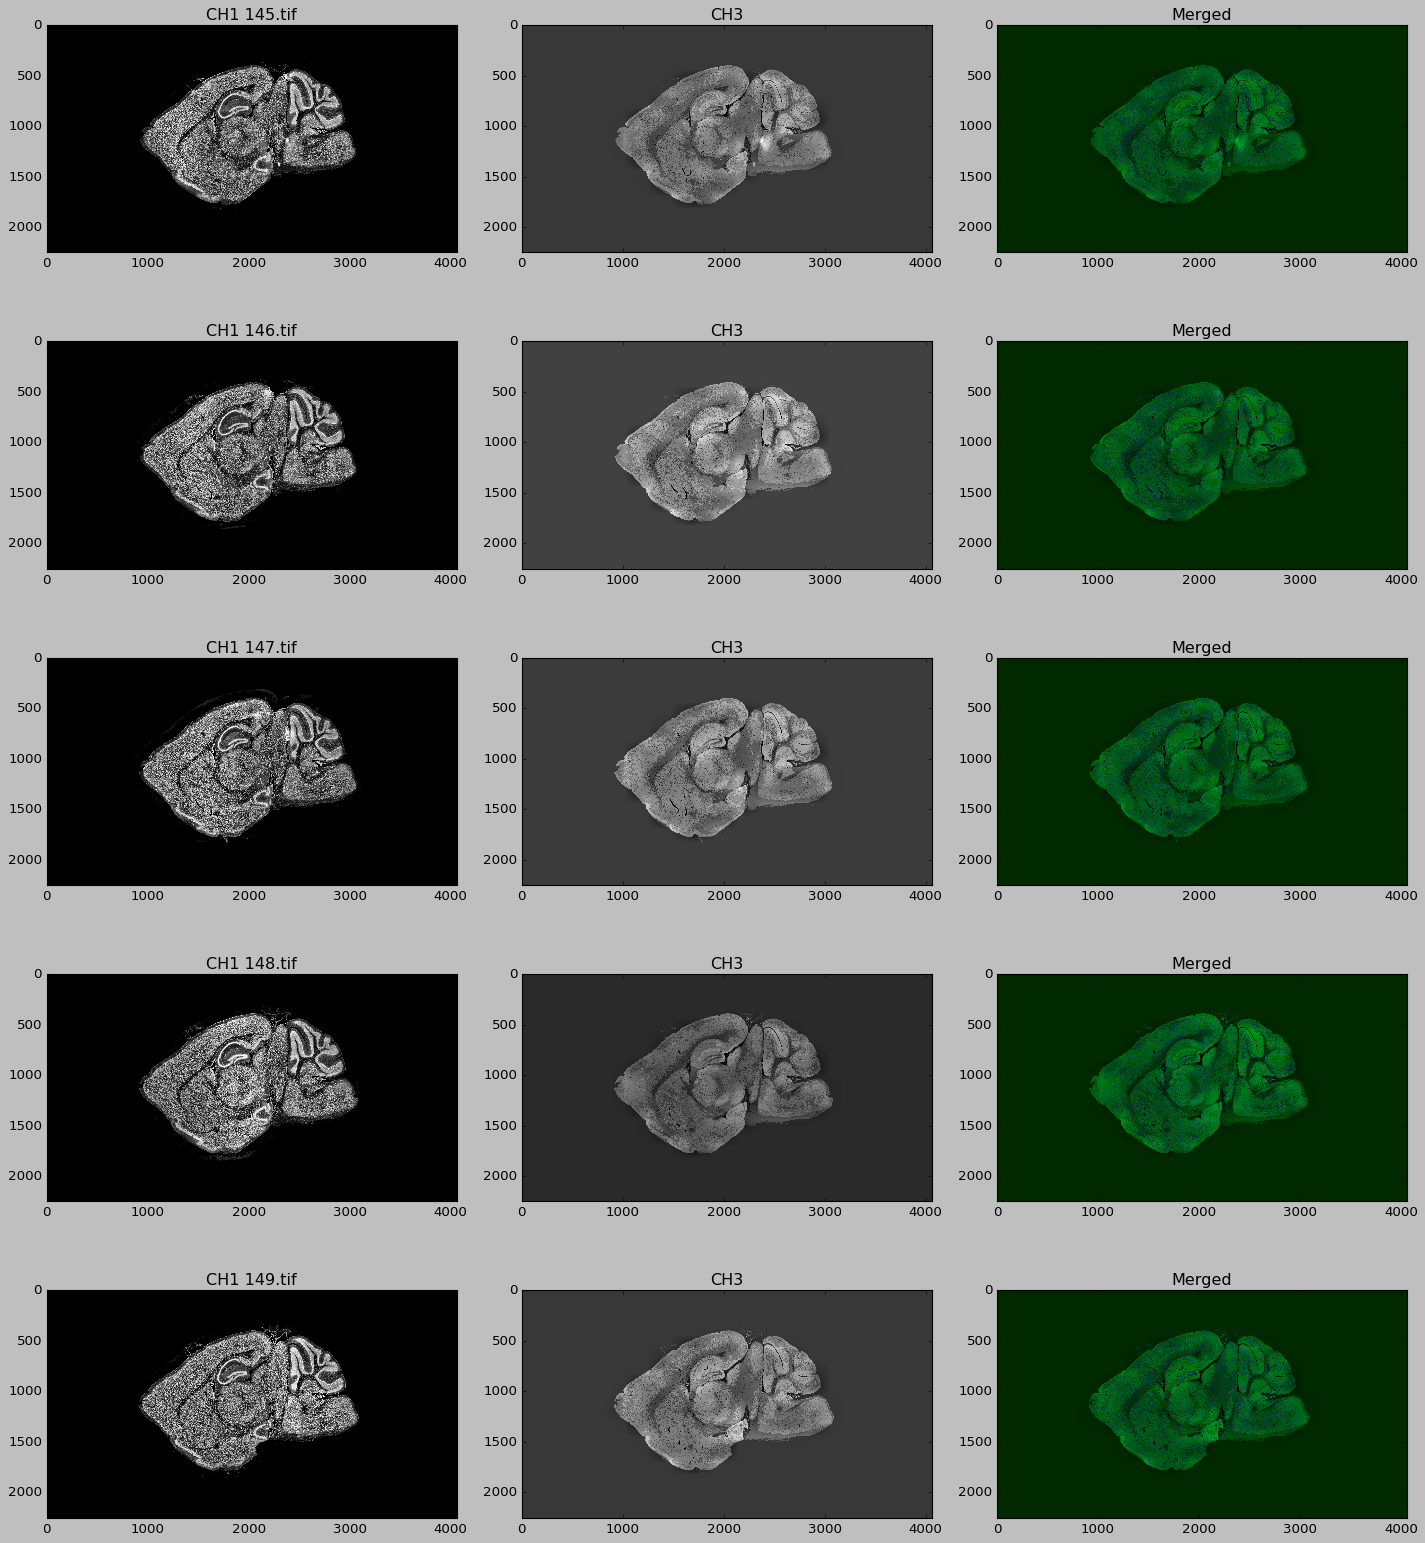

In [26]:
low_clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(18, 18))
high_clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(18, 18))

no_img = 2
ch1_inputs = []
ch3_inputs = []
titles = []
img_outputs = []
start, finish = (145,150)
for ch1_file, ch3_file in tqdm(zip(ch1_files[start:finish], ch3_files[start:finish])):
    ch1_infile = os.path.join(CH1, ch1_file)
    ch3_infile = os.path.join(CH3, ch3_file)
    ch1_img = cv2.imread(ch1_infile, cv2.IMREAD_UNCHANGED)
    ch3_img = cv2.imread(ch3_infile, cv2.IMREAD_UNCHANGED)
    name = '{}'.format(ch1_file)
    ch1_img = low_clahe.apply(ch1_img)
    ch1_img = ch1_img * 0.25

    ch1_img8 = (ch1_img/256).astype('uint8')
    ch3_img8 = (ch3_img/256).astype('uint8')
    ch1_inputs.append(ch1_img8)
    titles.append(name)
    ch3_img8 = high_clahe.apply(ch3_img8)
    #mask = ch3_img8 == 0
    #ch3_img8[mask] = 255
    ch3_inputs.append(ch3_img8)
    r = np.zeros(ch1_img8.shape).astype(np.uint8)
    rgb_uint8 = np.dstack((r,ch3_img8,ch1_img8)) .astype(np.uint8)
    bgr_uint8 = np.dstack((ch1_img8, ch3_img8, r)) .astype(np.uint8)
    #img = ch1_img/no_img + ch3_img/no_img
    outpath = os.path.join(OUTPUT, ch1_file)
    cv2.imwrite(outpath, bgr_uint8)
                  
    img_outputs.append(rgb_uint8)
    
fig, ax = plt.subplots(nrows=len(titles), ncols=3, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for ch1, ch3, name, fileout in zip(ch1_inputs, ch3_inputs, titles, img_outputs):
    ax[i,0].set_title('CH1 {}'.format(name))
    ax[i,0].imshow(ch1, cmap="gray")
    ax[i,1].set_title('CH3')
    ax[i,1].imshow(ch3, cmap="gray")
    ax[i,2].set_title('Merged')
    ax[i,2].imshow(fileout, cmap="gray")

    i += 1
# for wide images, 18,4 * len is good
fig.set_size_inches(np.array([18, 4 * len(titles)]), forward=False)
plt.tight_layout()
plt.show()